In [1]:
!git pull https://github.com/Francesco215/Quantum-diffusion.git

From https://github.com/Francesco215/Quantum-diffusion
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from IPython.display import clear_output



from src import *
from tqdm.auto import tqdm

#device=torch.device('cpu')
if torch.backends.mps.is_available():
    device = torch.device("mps")

NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [18]:
testset[1][0].unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    plt.imshow(make_grid(img[:4]).cpu().detach().permute(1,2,0))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [5]:
timesteps=1000

times=torch.ones(len(images))*timesteps*0.1
#alpha=cosine_schedule(times,timesteps)
k=0.5
alpha=torch.ones(len(images))-.2

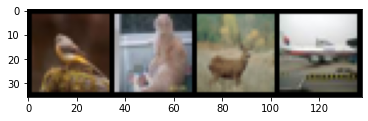

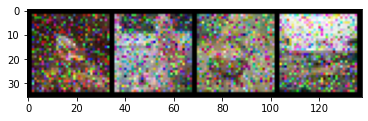

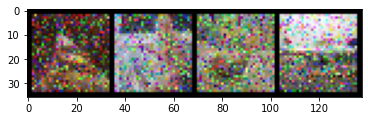

bird  cat   deer  plane


In [6]:
imshow(torchvision.utils.make_grid(images))

images=decimal_to_binary(images)
noisy_images_digital=bernoulli_noise(images,alpha,k)
noisy_images_digital=binary_to_decimal(noisy_images_digital)

images=binary_to_qubits(images)
noisy_images=gaussian_noise(images,alpha,k)
noisy_images=qubit_to_decimal(noisy_images)

images=qubit_to_decimal(images)

imshow(torchvision.utils.make_grid(noisy_images))
imshow(torchvision.utils.make_grid(noisy_images_digital))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
n_bits = 8

model = Unet(
    dim = 32,
    channels = 3,
    dim_mults = (1, 2, 4, 8),
    bits = n_bits,
).to(device)

diffusion = BitDiffusion(model, image_size = 32).to(device)
diffusion.losses = []

def cross_entropy(prediction,target):
    ce= target*torch.log2(prediction + 1e-8) + (1-target)*torch.log2(1-prediction + 1e-8)
    ce=torch.tanh(ce/20)*20
    return -torch.mean(ce)

def loss_function(predictions, target, k):
    predictions=predictions+.5
    probabilities=torch.sin(predictions*np.pi/2)**2
    target=target+.5
    return cross_entropy(probabilities,target)

optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-3)

epoch= 1, steps=2
------------------------------
noised images cross entropy loss: 0.5973820090293884
cross entropy loss: 1.8008661270141602
------------------------------
bit-wise MSE between the noised image and the original image:0.13341179490089417
bit-wise MSE between the denoised image and the original image:0.40981897711753845
------------------------------
MSE between the noised image and the original:0.0270182304084301
MSE between the denoised image and the original:0.03059895895421505


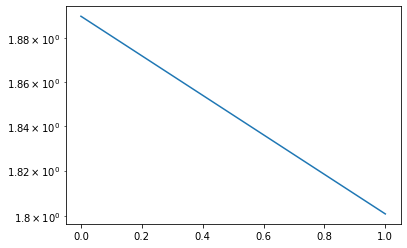

noised images


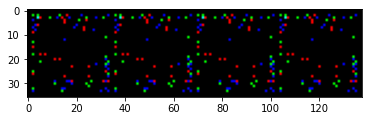

denoised images


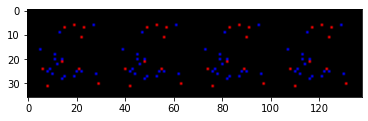

original images


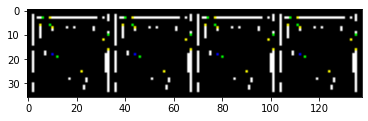

  0%|          | 38/12500 [01:04<5:52:01,  1.69s/it]


KeyboardInterrupt: 

In [8]:
# Train the model
for epoch in range(10):
    for i, (images, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        
        images = images.to(device)
        images = decimal_to_qubits(images)

        alpha = torch.rand(len(images),device=device)
        noised_images = gaussian_noise(images, alpha, k)
        

        predictions = diffusion.forward(noised_images, alpha, self_conditioning=False)

        loss = loss_function(predictions, images, k)
        loss.backward()
        optimizer.step()
        diffusion.losses.append(loss.item())

        if i % 40 == 1:
            clear_output(wait=True)
            print(f'epoch= {epoch + 1}, steps={i + 1}') 
            print(f'------------------------------')
            print(f"noised images cross entropy loss: {loss_function(noised_images, images,k)}")
            print(f'cross entropy loss: {loss_function(predictions, images, k)}')
            print(f'------------------------------')

            mse=torch.nn.functional.mse_loss(images, noised_images)
            print(f'bit-wise MSE between the noised image and the original image:{mse}')
            mse=torch.nn.functional.mse_loss(images, predictions)
            print(f'bit-wise MSE between the denoised image and the original image:{mse}')
            print(f'------------------------------')


            noised_images=qubit_to_decimal(noised_images, n_bits)
            img_predictions=qubit_to_decimal(predictions, n_bits)
            images=qubit_to_decimal(images, n_bits)

            mse=torch.nn.functional.mse_loss(images, noised_images)
            print(f'MSE between the noised image and the original:{mse}')
            mse=torch.nn.functional.mse_loss(images, img_predictions)
            print(f'MSE between the denoised image and the original:{mse}')
            


            plt.semilogy(diffusion.losses)
            plt.show()
            
            print("noised images")
            imshow(noised_images)

            print("denoised images")
            imshow(img_predictions)

            print("original images")
            imshow(images)



In [ ]:
torch.any(torch.isnan(noised_images))

tensor(True, device='mps:0')

In [ ]:
#!pip install pytorch-fid
from pytorch_fid import fid_score
fid_score()
!python -m pytorch_fid "path/to/dataset1" "path/to/dataset2"